In [51]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats

In [41]:
opp_df = pd.read_parquet('../../data/cleaned/opportunity/opportunity.parquet')

In [42]:
alpha = 0.05

### Q1. Is time taken between stage transitions significantly different across geographies?

- Here, the null hypothesis **h0**, is that 2 geographies have same mean time taken.
- **h1** is that they have different mean.

In [43]:
time_diff_data = opp_df.groupby(['opportunity_id',
                                 'transition_to_stage','transition_from_stage_name','geography'],
                                as_index=False).agg({'transition_to_timestamp':'max',
                                                     'transition_from_timestamp':'min'})

In [44]:
time_diff_data['transition_time'] = (time_diff_data['transition_to_timestamp'] - time_diff_data['transition_from_timestamp']).dt.total_seconds()/(3600*24)

In [45]:
geo_time_data = time_diff_data.groupby(['geography', 'transition_from_stage_name', 'transition_to_stage'], 
                                       as_index = False)['transition_time'].mean()

In [46]:
geo = dict()
for i in geo_time_data['geography'].unique():
    key_ = i
    geo[i]= geo_time_data[geo_time_data['geography'] == i]



In [48]:
print("\nCase_1\nh0 for Geo 1 and Geo 2\nReject Null Hypothesis? :",stats.f_oneway(geo['Geo 1']['transition_time'], geo['Geo 2']['transition_time'])[1].round(3)>alpha)
print("\nCase_2\nh0 for Geo 1 and Geo 3\nReject Null Hypothesis? :",stats.f_oneway(geo['Geo 1']['transition_time'], geo['Geo 3']['transition_time'])[1].round(3)>alpha)
print("\nCase_3\nh0 for Geo 1 and Geo 4\nReject Null Hypothesis? :",stats.f_oneway(geo['Geo 1']['transition_time'], geo['Geo 4']['transition_time'])[1].round(3)>alpha)
print("\nCase_4\nh0 for Geo 1 and Geo 5\nReject Null Hypothesis? :",stats.f_oneway(geo['Geo 1']['transition_time'], geo['Geo 5']['transition_time'])[1].round(3)>alpha)
print("\nCase_5\nh0 for Geo 2 and Geo 3\nReject Null Hypothesis? :",stats.f_oneway(geo['Geo 2']['transition_time'], geo['Geo 3']['transition_time'])[1].round(3)>alpha)
print("\nCase_6\nh0 for Geo 2 and Geo 4\nReject Null Hypothesis? :",stats.f_oneway(geo['Geo 2']['transition_time'], geo['Geo 4']['transition_time'])[1].round(3)>alpha)
print("\nCase_7\nh0 for Geo 2 and Geo 5\nReject Null Hypothesis? :",stats.f_oneway(geo['Geo 2']['transition_time'], geo['Geo 5']['transition_time'])[1].round(3)>alpha)
print("\nCase_8\nh0 for Geo 3 and Geo 4\nReject Null Hypothesis? :",stats.f_oneway(geo['Geo 3']['transition_time'], geo['Geo 4']['transition_time'])[1].round(3)>alpha)
print("\nCase_9\nh0 for Geo 3 and Geo 5\nReject Null Hypothesis? :",stats.f_oneway(geo['Geo 3']['transition_time'], geo['Geo 5']['transition_time'])[1].round(3)>alpha)
print("\nCase_10\nh0 for Geo 4 and Geo 5\nReject Null Hypothesis? :",stats.f_oneway(geo['Geo 4']['transition_time'], geo['Geo 5']['transition_time'])[1].round(3)>alpha)


Case_1
h0 for Geo 1 and Geo 2
Reject Null Hypothesis? : False

Case_2
h0 for Geo 1 and Geo 3
Reject Null Hypothesis? : True

Case_3
h0 for Geo 1 and Geo 4
Reject Null Hypothesis? : False

Case_4
h0 for Geo 1 and Geo 5
Reject Null Hypothesis? : True

Case_5
h0 for Geo 2 and Geo 3
Reject Null Hypothesis? : True

Case_6
h0 for Geo 2 and Geo 4
Reject Null Hypothesis? : True

Case_7
h0 for Geo 2 and Geo 5
Reject Null Hypothesis? : True

Case_8
h0 for Geo 3 and Geo 4
Reject Null Hypothesis? : True

Case_9
h0 for Geo 3 and Geo 5
Reject Null Hypothesis? : True

Case_10
h0 for Geo 4 and Geo 5
Reject Null Hypothesis? : True


In [9]:
mean_geo_time = [geo[i]['transition_time'].mean() for i in geo_time_data['geography'].unique()]

TypeError: set() got an unexpected keyword argument 'xlabel'

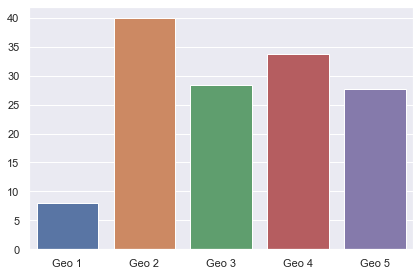

In [50]:
sns.barplot(x = ['Geo 1', 'Geo 2', 'Geo 3', 'Geo 4', 'Geo 5'], y = mean_geo_time)
sns.set(xlabel = 'Geography', ylabel = 'Average time spent')

### Q2. Are Losses (Opportunity lines in Lost stage) more likely to happen in early stages (Qualify and define)

- Here, the null hypothesis **h0**, is that losses happen more in early stages.
- **h1** is that losses happen less in early stages.

In [11]:
stage_df = opp_df[opp_df['transition_to_stage'] != opp_df['transition_from_stage_name']][['opportunity_id',
                                                                                         'transition_from_stage_name',
                                                                                         'transition_to_stage']]

In [12]:
stage_df['early_stages'] = stage_df['transition_from_stage_name'].apply(lambda x: x in ['Stage 0', 'Stage 5', 'Stage 6'])
stage_df['lost'] = stage_df['transition_to_stage'].apply(lambda x: x in ['Stage 1', 'Stage 8'])

In [13]:
early_df = stage_df[stage_df['early_stages'] == True]
non_early_df = stage_df[stage_df['early_stages'] == False]
non_early_df = non_early_df[(non_early_df['transition_from_stage_name'] == 'Stage 2') | 
                            (non_early_df['transition_from_stage_name'] == 'Stage 3') |
                            (non_early_df['transition_from_stage_name'] == 'Stage 7')].copy()

In [14]:
X1 = early_df['lost'].sum()
X2 = non_early_df['lost'].sum()
n1 = early_df['lost'].count()
n2 = non_early_df['lost'].count()
p1 = X1/n1
p2 = X2/n2
p0 = (X1+X2)/(n1+n2)

z_score = p1 - p2 / np.sqrt(p0 * (1 - p0) * (1/n1 + 1/n2))

In [15]:
z_crit = stats.norm.ppf(alpha)

In [16]:
print('The z-score is : ', z_score, ' and the critical z-score for 5% significance is ', z_crit)
print('So null hypothesis is rejected')

The z-score is :  -17.020246839523903  and the critical z-score for 5% significance is  -1.6448536269514729
So null hypothesis is rejected


In [36]:
cross_tab = pd.crosstab(stage_df['early_stages'], stage_df['lost'])
cross_tab
# ta_analysis.get_bivariate_plots(df=stage_df, x_cols='early_stages', y_cols='')

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


lost,False,True
early_stages,,
False,3883,276
True,8407,283


### Q3. Does the proportion of Won lines in an Opportunity significantly different across Product Categories?

- Here, the null hypothesis **h0**, is that the proportion of Won lines in an Opportunity significantly similar across Product Categories.
- **h1** is that the proportion of Won lines in an Opportunity significantly different across Product Categories.

In [18]:
pro_seg_df = opp_df[['core_product_segment', 'opportunity_status']].copy()

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [19]:
pro_seg_df['target'] = np.where(pro_seg_df['opportunity_status'] == 'Closed/Won', True, False)

In [32]:
ct = pd.crosstab(pro_seg_df['core_product_segment'], pro_seg_df['target'])
stat, p, dof, expected = stats.chi2_contingency(ct)

if p < alpha:
    print('Reject Null Hypothesis')
else:
    print('Failed to Reject Null Hypothesis')

print('p-value:', round(p, 3))


Reject Null Hypothesis
p-value: 0.0


`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


Null Hypothesis is reject i.e, proportion of won is different for different product categories.

In [33]:
ct['win_percentage'] = ct[True]/(ct[False] + ct[True])*100

In [34]:
ct

target,False,True,win_percentage
core_product_segment,,,
Core Prd Seg 1,20,0,0.000000
Core Prd Seg 10,5,0,0.000000
Core Prd Seg 11,43,18,29.508197
Core Prd Seg 2,456,86,15.867159
Core Prd Seg 3,118184,174125,59.568812
Core Prd Seg 4,6149,3677,37.421128
Core Prd Seg 5,4015,1305,24.530075
Core Prd Seg 6,430,195,31.200000
Core Prd Seg 7,171,65,27.542373
